In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
mvg_data_orig = pd.read_parquet("../../data/subway_only_dedup.parquet")

In [30]:
mvg_data = mvg_data_orig

mvg_data = mvg_data.drop(columns=['transportType', 'realtimeDepartureTime', 'timestamp'])
mvg_data = mvg_data[mvg_data.realtime]
mvg_data['onTime'] = mvg_data['delayInMinutes'] == 0

mvg_datetime = pd.to_datetime(mvg_data['plannedDepartureTime']).dt

mvg_data['hourOfDay'] = mvg_datetime.hour
mvg_data['minuteOfDay'] = mvg_datetime.hour * 60 + mvg_datetime.minute
mvg_data['dayOfWeek'] = mvg_datetime.day_of_week # Monday=0, Sunday=6
mvg_data['dayOfYear'] = mvg_datetime.day_of_year

# remove negative delay for bucketing
mvg_data = mvg_data[mvg_data['delayInMinutes'] >= 0]

bins = [-1, 2, 6, np.inf]
labels = ['ontime (0-2 min)', 'small delay (3-6 min)', 'delayed (6+ min)']
mvg_data['delayCategory'] = pd.cut(mvg_data['delayInMinutes'], bins=bins, labels=labels)

mvg_data = mvg_data.sample(500_000)

In [31]:
features = mvg_data.drop(['delayInMinutes', 'onTime', 'plannedDepartureTime', 'delayCategory'], axis=1)
target = mvg_data['delayCategory']

features = features.drop(['station', 'destination', 'label', 'realtime'], axis=1)
#features_encoded = pd.get_dummies(features)
features_encoded = features

X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [37]:
def train_and_evaluate_rf(estimators, X_train, y_train, X_val, y_val):
    """Trains a Random Forest and returns both train and validation F1-scores."""
    model = RandomForestClassifier(
        n_estimators=estimators,
        n_jobs=-1,
        class_weight='balanced',
        random_state=0
    )
    model.fit(X_train, y_train)
    
    # Calculate weighted F1-score instead of accuracy
    train_pred = model.predict(X_train)
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    
    val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, val_pred, average='weighted')
    
    return estimators, train_f1, val_f1


In [33]:
estimators_to_test = range(50, 1001, 10) 

# n_jobs=-1 here parallelizes the ENTIRE loop (runs multiple models at once)
results = Parallel(n_jobs=3)(
    delayed(train_and_evaluate_rf)(n, X_train, y_train, X_val, y_val) for n in estimators_to_test
)


KeyboardInterrupt: 

In [ ]:
training_results = {n: train_acc for n, train_acc, val_acc in results}
validation_results = {n: val_acc for n, train_acc, val_acc in results}

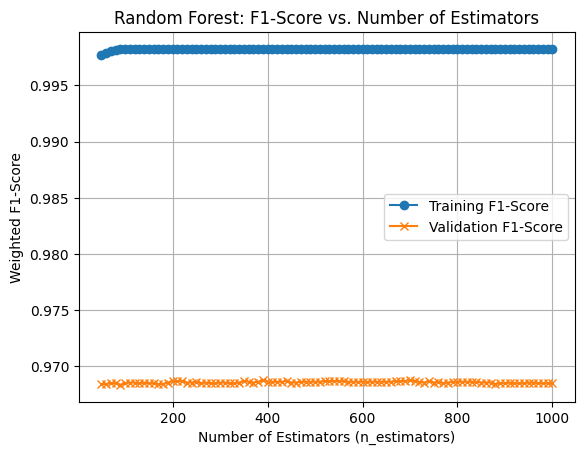

In [19]:
params, train_f1_scores = zip(*sorted(training_results.items()))
plt.plot(params, train_f1_scores, label="Training F1-Score", marker='o')

params, val_f1_scores = zip(*sorted(validation_results.items()))
plt.plot(params, val_f1_scores, label="Validation F1-Score", marker='x')

plt.title("Random Forest: F1-Score vs. Number of Estimators")
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Weighted F1-Score") # Update the y-axis label
plt.legend()
plt.grid(True)
plt.show()

In [20]:
best_parameter = max(validation_results, key=validation_results.get)

best_accuracy = validation_results[best_parameter]

print(f"The best parameter is: {best_parameter}")
print(f"With a validation accuracy of: {best_accuracy:.4f}")

The best parameter is: 390
With a validation accuracy of: 0.9688


In [38]:
best_parameter=390
final_model = RandomForestClassifier(
    n_estimators=best_parameter,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1,
    random_state=0
)

final_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed:    9.9s finished


,n_estimators,390
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


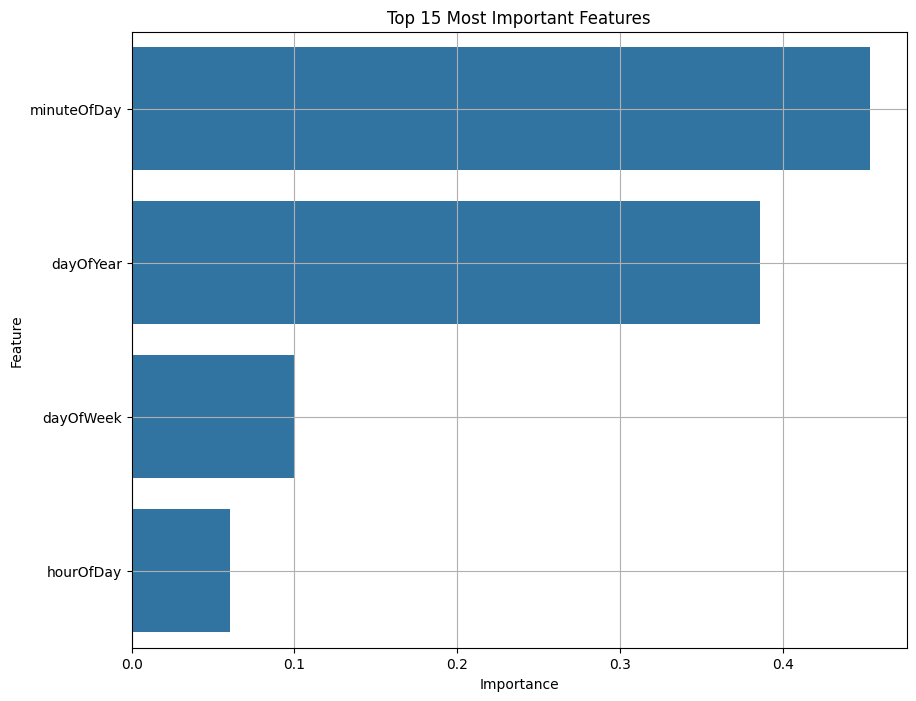

In [39]:
importances = final_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 390 out of 390 | elapsed:    0.2s finished


Classification Report:
                       precision    recall  f1-score   support

     delayed (6+ min)       0.05      0.04      0.04       231
     ontime (0-2 min)       0.99      0.99      0.99     74071
small delay (3-6 min)       0.02      0.02      0.02       698

             accuracy                           0.98     75000
            macro avg       0.35      0.35      0.35     75000
         weighted avg       0.98      0.98      0.98     75000



[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 390 out of 390 | elapsed:    0.2s finished


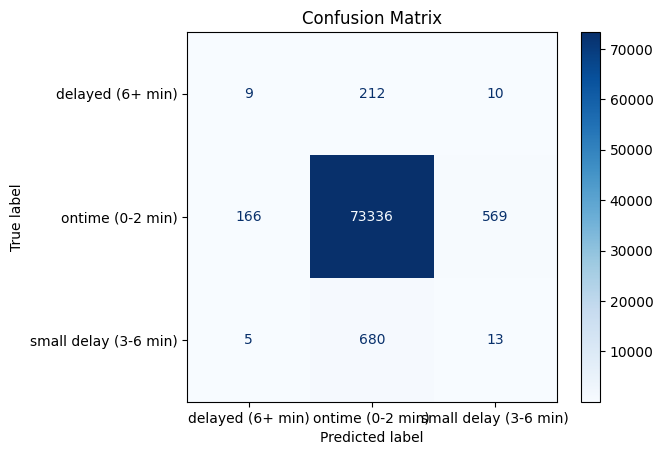

In [40]:
y_pred = final_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(
    final_model,
    X_test,
    y_test,
    cmap=plt.cm.Blues
)
disp.ax_.set_title('Confusion Matrix')
plt.show()